Run on: boat3-env (Python 3.7.15) environment

Augment audio files

code adapted from: https://github.com/musikalkemist/audioDataAugmentationTutorial/blob/main/5/audiomentationstutorial.py

see: https://www.youtube.com/watch?v=rPj9_rIBqNA

In [8]:
import librosa
import librosa.display # used for spec viewing
import soundfile as sf
import os 
import matplotlib.pyplot as plt

from audiomentations import Compose, AddGaussianNoise, PitchShift, TimeStretch, ClippingDistortion, Gain, SevenBandParametricEQ

In [24]:
audio_dir = r"C:/Users/bw339/OneDrive - University College London/Mars internship/Bomb classifier/data/processed_y_bombs"
output_folder = r"C:/Users/bw339/OneDrive - University College London/Mars internship/Bomb classifier/data/augmentation/augmented_y_bombs"
sample_rate = 8000

# list all the audio files in the directory
audio_files = [f for f in os.listdir(audio_dir) if f.endswith('.wav') or f.endswith('.WAV')]

repeat = 0 # this gets appended to the end of the file name to differentiate the augmented files


This function will apply augmentations to augio signals when used.

Each augmentation has a 0.5 chance of being used, and a range within it (or a default range) that determines the range within which the augmentation can be applied. As this range still includes zero values, the 0.5 chance of being used is applied as some may barely change the audio

In [25]:
# Raw audio augmentation
augment_raw_audio = Compose(
    [
        AddGaussianNoise(min_amplitude=0.0001, max_amplitude=0.0005, p=0.5), # good
        PitchShift(min_semitones=-2, max_semitones=12, p=0.5), #set values so it doesnt shift too low, rmeoving bomb signal
        TimeStretch(p = 0.5), # defaults are fine
        ClippingDistortion(0, 5, p = 0.5), # tested params to make sure its good
        Gain(-10, 5, p = 0.5), # defaults are fine
        SevenBandParametricEQ(-12, 12, p = 0.5)
    ]
)

# Could try reverse - inverting audio has ben used (though they didnt comment if it helped) https://arxiv.org/pdf/2106.13043.pdf
# don't use normalise as it over amplifies background noise, gain already handles this fine
# don;t use GaussianSNR as AddGaussianNoise handles this fine
# don't aplpy padding as bombs may fall right at the start of a track
# don't need PeakingFilter, SevenBandParametricEQ does the same job better
# could try tank distortion, but might be similar to AddGaussianNoise
# could use shift but think I'll stick to timestretch - this can introduce zeros at end though

In [26]:
for file in range(len(audio_files)):
    # find file path and load file
    audio_path = os.path.join(audio_dir, audio_files[file])
    audio, sr = librosa.load(audio_path)

    # apply augmentation function
    augmented_signal = augment_raw_audio(audio, sr)
    
    # Save the augmented signal in output_folder
    output_path = os.path.join(output_folder, audio_files[file][:-4] + "_augmented" + str(repeat) + ".wav")
    sf.write(output_path, augmented_signal, sr)

KeyboardInterrupt: 

In [4]:
def view_multiple_mel_spec(filename_list, sr, audio_dir):
  """Creates a spectrogram plot of multiple audio files in the mel scale.
  Pass in the list of filenames as strings and the sample rate as an integer."""

  #set hop length for mel_spec and.specshow()
  hop_length = 64

  n = len(filename_list)
  
  # create a figure with n subplots, where n is the number of files in the list
  fig, ax = plt.subplots(1, n, figsize=(5*n, 5))
  
  # iterate over the list of filenames
  for i, filename in enumerate(filename_list):
    file_path = audio_dir + filename
    audio, sample_rate = librosa.load(file_path, sr = sr)

    # compute the mel spectrogram of the audio
    mel_spec = librosa.feature.melspectrogram(y=audio, sr=sample_rate, n_mels=128,
                                              win_length=1024, hop_length=hop_length)

    # convert the power spectrogram to decibel (dB) units 
    mel_spec_db = librosa.power_to_db(S=mel_spec, ref=1.0) 

    # plot the spectrogram for each file in a separate subplot
    librosa.display.specshow(mel_spec_db, sr=sample_rate, ax=ax[i],
                             y_axis='mel', x_axis='time',  
                             vmin = -100, vmax = 0, 
                             cmap = 'magma', hop_length=hop_length)
    ax[i].set_yticks([200, 500, 1000, 2000, 4000])
    ax[i].set_ylim(0,4000)

  # create the colorbar for the last plot only
  cbar = fig.colorbar(ax[-1].collections[0], ax=ax, orientation='vertical')



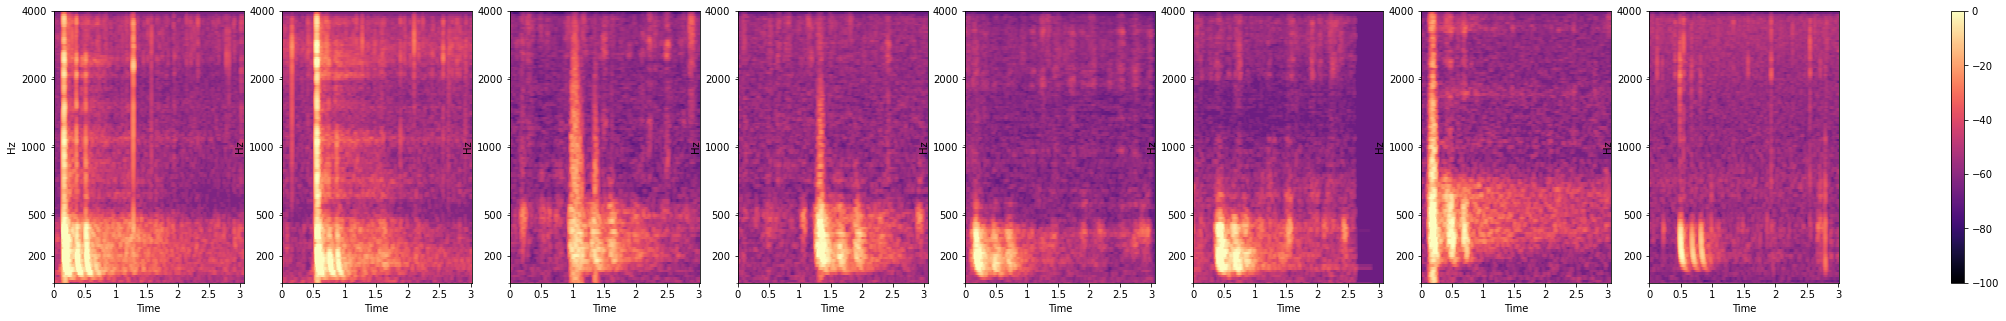

In [465]:
# list all the audio files in the directory
augmented_files = [f for f in os.listdir(output_folder) if f.endswith('.wav') or f.endswith('.WAV')]

# view 8 augmented files
# select every 5th item in augmented_files up to item 20, change if adding more or less than 5 repeats
view_multiple_mel_spec(augmented_files[1:40:5], sample_rate, output_folder)

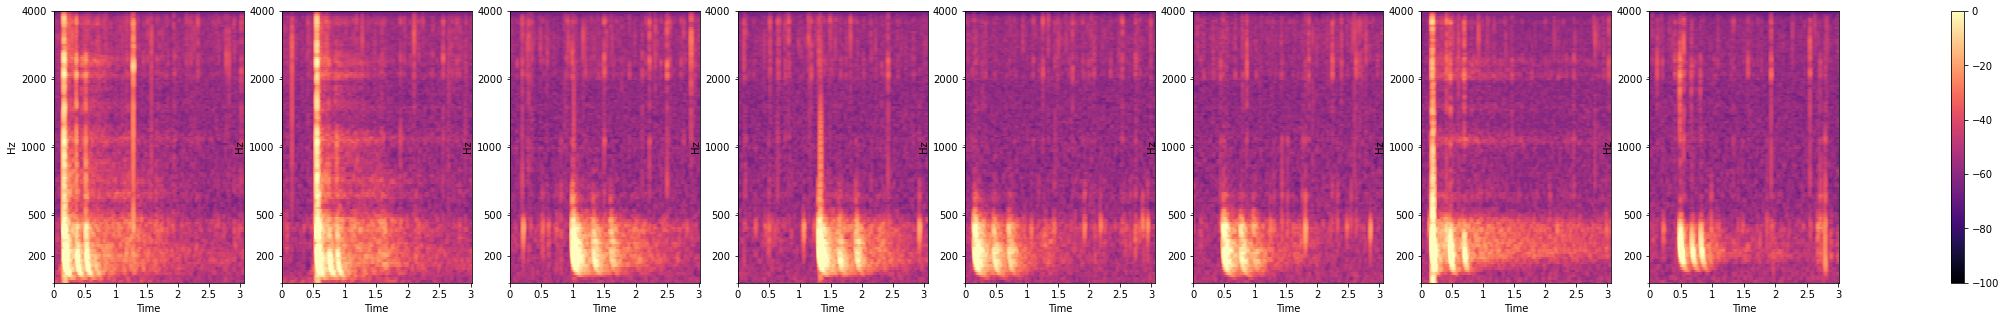

In [468]:
# view the 8 original files
view_multiple_mel_spec(audio_files[0:8], sample_rate, audio_dir)